# "Colorless" Artificial Reverbation
[Allpass filter from 1961 IRE paper by M. R. Schroeder and B. F. Logan](http://www2.ece.rochester.edu/courses/ECE472/resources/Papers/Schroeder_1961.pdf)


Allpass reverb from 1962 JAES paper *Natural Sounding Artificial Reverberation* by M. R. Schroeder

In [1]:
%matplotlib inline
%load_ext cython

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import wave

from lib.utils import process_file

from IPython import display
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [5.333, 3]
plt.rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans','Lucida Grande', 'Verdana']

TAU = 2 * np.pi  

![Allpass Delay](img/allpass_filter.png)

In [2]:
%%cython -+
import cython
import numpy as np


@cython.cclass
class RingBuffer:
    buffer: np.double[:]
    buffer_view: np.double[:,::1]
    length: np.uintc
    write_pointer: np.uintc
    read_pointer: np.uintc

    def __cinit__(self, length: np.uintc) -> None:
        self.buffer = np.zeros(length, dtype=np.double)
        self.buffer_view = self.buffer
        self.length = length
        self.write_pointer = 0
        self.read_pointer = 1

    @cython.ccall
    @cython.boundscheck(False)
    @cython.wraparound(False)
    def push(self, input_: np.double):
        self.buffer_view[self.write_pointer] = input_
        self.write_pointer = (self.write_pointer + 1) % self.length
        self.read_pointer = (self.write_pointer + 1) % self.length

    @cython.ccall
    def clear(self):
        for _index in range(self.length):
            self.push(0.0)

    def __getitem__(self, index: int) -> np.double:
        if index < 0:
            return self.buffer_view[(self.write_pointer - index) % self.length]
        else:
            return self.buffer_view[(self.read_pointer + index) % self.length]


@cython.cclass
class Delay:
    """Circular buffer delay"""
    stereo: cython.bool
    output: np.double
    delay_length: np.uintc
    delay_line: RingBuffer

    def __cinit__(self, sample_rate: np.uintc, delay_ms: np.float, delay_samples: np.uintc = 0):
        self.stereo = False
        self.output = 0.0
        if delay_samples > 0:
            self.delay_length = delay_samples
        else:
            self.delay_length = int(delay_ms * (sample_rate / 1000.0))

        self.delay_line = RingBuffer(self.delay_length)
        self.clear()

    def __getattr__(self, output):
        return self.output    

    @cython.ccall
    def tick(self, input_):
        """Run delay for 1 sample"""
        self.output = self.delay_line[-1]
        self.delay_line.push(input_)

    @cython.ccall
    def clear(self):
        """Flush delay line, setting all values to 0.0"""
        for _index in range(self.delay_length + 1):
            self.delay_line.push(0.0)


@cython.cclass
class CombFilter:
    """Comb filter"""
    delay: Delay
    coeff: np.uintc
    output: np.double

    def __cinit__(self, sample_rate: np.uintc, delay_ms: np.float, coeff: np.uintc):
        self.delay = Delay(sample_rate, delay_ms)
        self.coeff = coeff
        self.output = 0.0

    @cython.ccall
    def tick(self, input_: np.double):
        """Run delay for 1 sample"""
        delay_input: np.double = input_ + self.coeff * self.delay.output
        self.output = self.delay.output
        self.delay.tick(delay_input)

    @cython.ccall
    def clear(self):
        """Flush delay line, setting all values to 0.0"""
        self.delay.clear()

    def __getattr__(self, output):
        return self.output    


@cython.cclass
class AllPassDelay(CombFilter):
    """All pass delay"""
    delay: Delay
    coeff: np.uintc
    output: np.double

    @cython.ccall
    def tick(self, input_: np.double):
        """Run delay for 1 sample"""
        delay_input: np.double = input_ + self.coeff * self.delay.output
        self.output = ((-1.0 * self.coeff * delay_input) +
                       ((1.0 - self.coeff**2) * self.delay.output))

        self.delay.tick(delay_input)


![Schroeder Reverb](img/schroeder_reverb.png)

In [3]:
class SchroederReverb:
    """Schroeder reverbator, as described in 'Natural Sounding Artificial Reverberation', Fig. 5"""
    def __init__(self, gain_1, gain_2, delay_length, allpass_matrix, sample_rate):
        self.stereo = False
        self.size = len(allpass_matrix)
        self.gain_1 = gain_1
        self.gain_2 = gain_2
        self.output = 0.0

        self.allpass_reverb = [AllPassDelay(sample_rate, allpass_matrix[allpass][0],
                               allpass_matrix[allpass][1]) for allpass in range(self.size)]

        self.delay = Delay(sample_rate, delay_length)

    def tick(self, input_):
        """Run reverb for 1 sample"""
        self.delay.tick(input_ + self.gain_2 * self.allpass_reverb[-1].output)
        for index, allpass in enumerate(self.allpass_reverb):
            if index == 0:
                allpass.tick(self.delay.output)
            else:
                allpass.tick(self.allpass_reverb[index - 1].output)

        self.output = (self.allpass_reverb[-1].output * (1.0 - self.gain_1**2)) + (input_ * self.gain_1 * -1.0)
    
    def clear(self):
        """Flush delay lines, setting all values to 0.0"""
        self.delay.clear()
        for allpass in self.allpass_reverb:
            allpass.clear()


In [4]:
delay_length = 43
allpass_matrix = [[100, 0.5],
                  [68, -0.5],
                  [60, 0.5],
                  [19.7, 0.5],
                  [5.85, 0.5]]

input_file = "./input.wav"
output_file = "./output.wav"


with wave.open(input_file, "r") as wave_file:
    sample_rate = wave_file.getframerate()

reverb = SchroederReverb(0.33, 1.5, delay_length, allpass_matrix, sample_rate)

process_file(input_file, output_file, reverb)
display.Audio(filename=output_file)


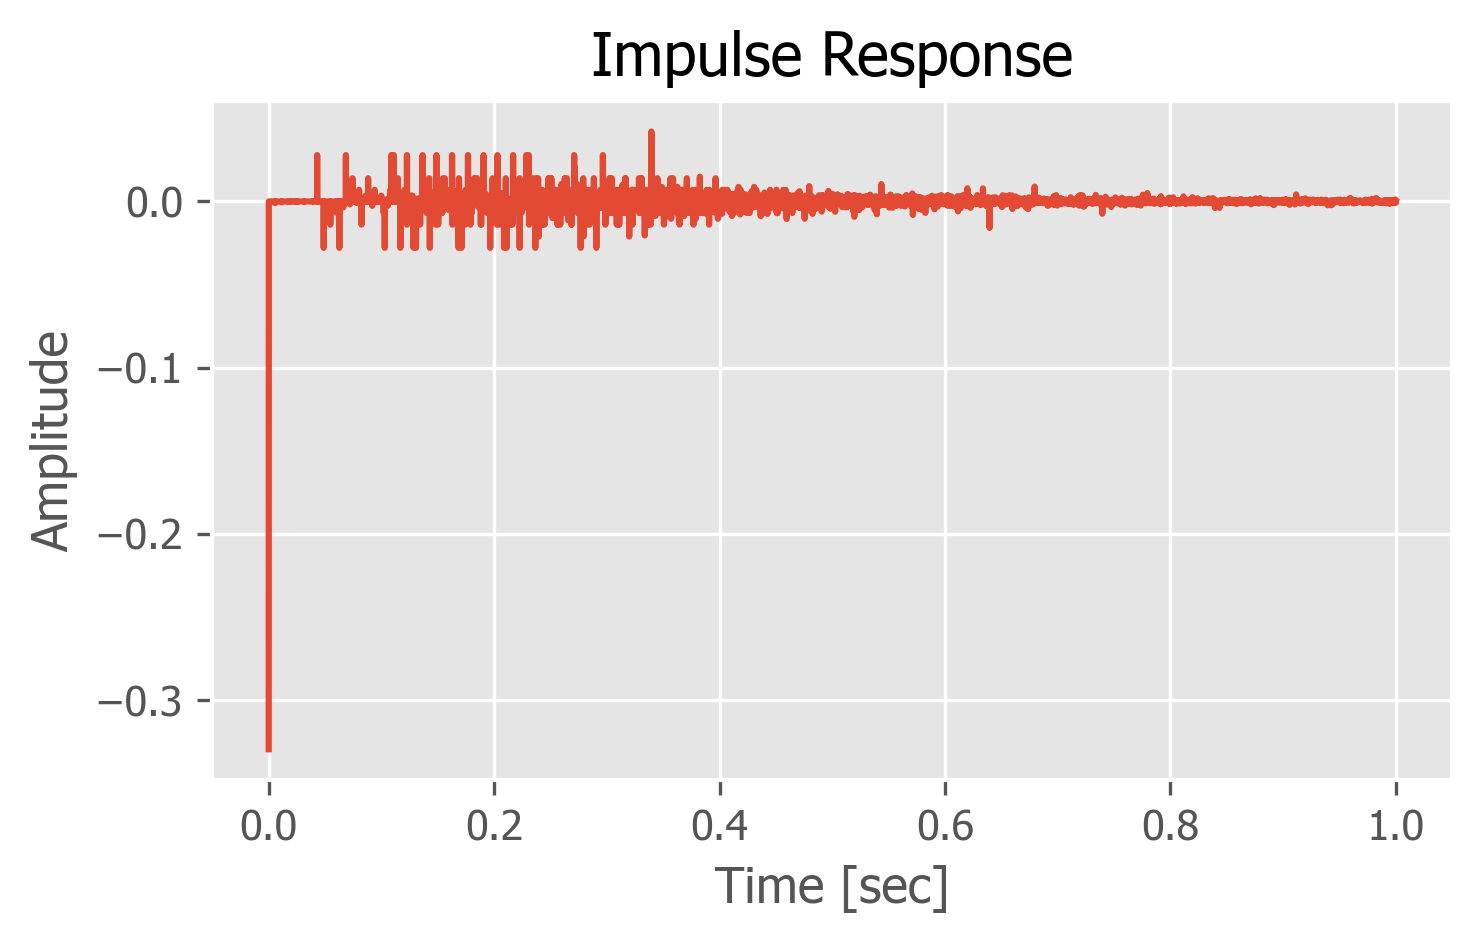

In [5]:
reverb.clear()

time = 1.0
samples = int(time * sample_rate)
x = np.linspace(0.0, time, samples, endpoint=False)
input = signal.unit_impulse(x.size)

output = np.zeros(input.size)
for index, sample in enumerate(input):
    reverb.tick(sample)
    output[index] = reverb.output

plt.plot(x, output)
plt.title('Impulse Response')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')
plt.show()

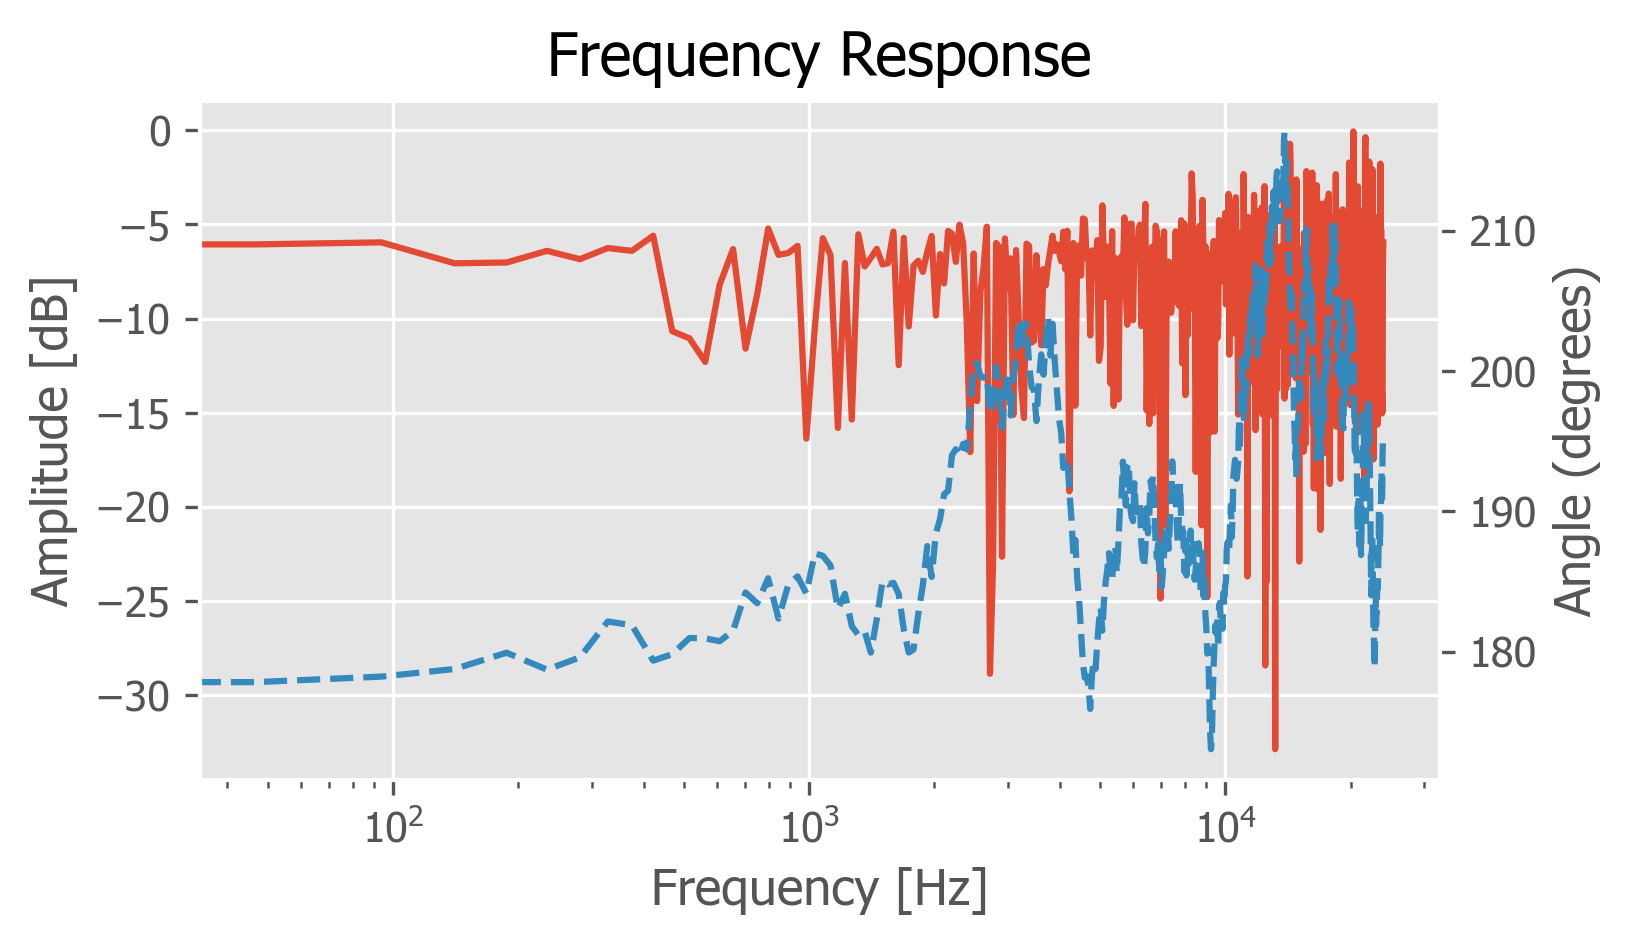

In [6]:
w, h = signal.freqz(output, fs=48000)
fig, ax1 = plt.subplots()

ax1.set_title('Frequency Response')
ax1.semilogx(w, 20 * np.log10(abs(h)), 'C0-')
ax1.set_ylabel('Amplitude [dB]')
ax1.set_xlabel('Frequency [Hz]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h, deg=True))
ax2.plot(w, angles,'C1--')
ax2.set_ylabel('Angle (degrees)')
ax2.grid()
ax2.axis('tight')

plt.show()